In [26]:
import time
import itertools as it

import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from IPython import display

from Node.functions import *
from Node.Node import Control_node
from Plant.Plant import Plant
from sklearn.preprocessing import normalize

In [27]:
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
B1 = np.random.rand(2, 2)
B2 = np.random.rand(2, 2)

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.random.rand(2, 2)
A2 = np.random.rand(2, 2)

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.random.rand(1, 2)
R2 = np.random.rand(1, 2)

# Initial behavior
behav_1 = np.random.rand(1, 2)
behav_2 = np.random.rand(1, 2)

# transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
T1 = np.array([0.2])
T2 = np.array([0.2])

color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]

# get the state observation (behaviors of others)
def sense(inputs):
    perception = inputs
    return perception

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a control signal
def control(error, behavioral_model, previous_output):
    control_signal = chaotic_controller(behavioral_model, 0.01, error)
    return control_signal

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    new_state[new_state > 1] = 1
    new_state[new_state < 0] = 0
    return new_state


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# adjusts reference given error
def reference_update_true(reference, error):
    k = 0.1
    reference = reference - (error * k)
    reference[reference > 1] = 1
    reference[reference < 0] = 0
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate * previous_state) + (behavioral_model * previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate


agent1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)
plant1 = Plant(transition_matrix=T1, transition_function=transition, state=behav_1)

agent2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
system_estimate=A2, reference=R2, init_behavior=behav_2)
plant2 = Plant(transition_matrix=T2, transition_function=transition, state=behav_2)

In [28]:
%matplotlib inline
np.random.seed(11)
trials = 1000
color = (0.1,0.2,0.8,0.1)
agent1_control = []
agent2_control = []
agent1_behaviors = []
agent2_behaviors = []
agent1_error = []
agent2_error = []
t9 = ['-1', '0', '50', '100', '150', '200', '150', '100', '50', '0',  '-1']

b1 = behav_1
b2 = behav_2

for t in range(trials):
    color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
    color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
    #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
    #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
    b1_control = agent1.go(b2)   
    b2_control = agent2.go(b1)

    agent1_control.append(agent1.get_output())
    agent2_control.append(agent2.get_output())

    b1 = plant1.transition(b1_control)
    b2 = plant2.transition(b2_control)

    agent1_behaviors.append(b1)
    agent2_behaviors.append(b2)

    # avg_abs_error = np.sum(abs(dif))/len(dif)
    agent1_error.append(np.sum(np.absolute(agent1.get_error()))/len(agent1.get_error()))
    agent2_error.append(np.sum(np.absolute(agent2.get_error()))/len(agent2.get_error()))
    # agent1_error.append(np.absolute(agent1.get_error()))
    # agent2_error.append(np.absolute(agent2.get_error()))

#     if t % 25 == 0:
#         pl.scatter(b1[0],-1+(t+1)/(trials+1),c=tuple(color1))
#         pl.scatter(b2[0],1-(t+1)/(trials+1),c=tuple(color2))
#         pl.scatter(agent1.get_reference()[0],1-(t+1)/(trials+1),c=tuple(color1), marker="_")
#         pl.scatter(agent2.get_reference()[0],-1+(t+1)/(trials+1),c=tuple(color2), marker="_")
#         display.clear_output(wait=True)
#         display.display(pl.gcf())
#         plt.legend([b1, b2, [agent1.get_reference()[0],0.00],[agent2.get_reference()[0],0.00]], labels=["Conformist Behavior", "Stubborn Behavior","Conformist Reference Signal", "Stubborn Reference Signal"])
#         lg = plt.gca().get_legend()
#         lg.legendHandles[0].set_color((0.1,0.1,0.8))
#         # lg.legendHandles[0].set_edgecolor((0.1,0.1,0.8))
#         lg.legendHandles[1].set_color((0.1,0.8,0.1))
#         # lg.legendHandles[1].set_edgecolor((0.1,0.8,0.1))
#         lg.legendHandles[2].set_color((0.1,0.1,0.8))
#         lg.legendHandles[3].set_color((0.1,0.8,0.1))
#         pl.title("Conformist Interaction with Stubborn Agent", fontsize=20, pad=20)
#         plt.xlabel("Behavior Value (X Position)", fontsize=16)
#         plt.ylabel("Time Step", fontsize=16)
#     #time.sleep(0.1)
# plt.gca().set_yticklabels(t9)


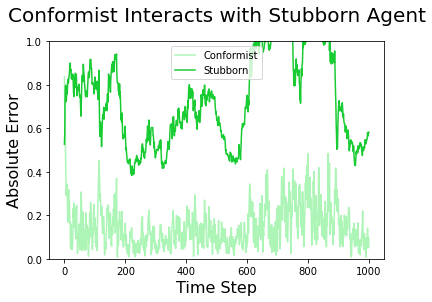

In [29]:
t = [n for n in range(trials)]
plt.plot(t, agent1_error, color=color2c,label="Conformist")
plt.plot(t, agent2_error, color=color2, label="Stubborn")
#plt.ylim([0, 1])
plt.legend()
plt.title("Conformist Interacts with Stubborn Agent", fontsize=20, pad=20)
plt.xlabel("Time Step", fontsize=16)
plt.ylabel("Absolute Error", fontsize=16)
plt.ylim(0,1)
plt.show()

In [30]:
# run experiments
experiments = 400
trials = 1000
color = (0.1,0.2,0.8,0.1)
np.random.seed(29)
agent1_errors = []
agent2_errors = []

#pl.scatter(R1[0],0, c=(0.1,0.8,0.8), edgecolors=[0.8,0.1,0.1], linewidths=1.5)
for e in range(experiments):
    agent1_control = []
    agent2_control = []
    agent1_behaviors = []
    agent2_behaviors = []
    agent1_error = []
    agent2_error = []
    R1 = np.random.rand(1,2)
    R2 = np.random.rand(1,2)

    # Initial behavior
    behav_1 = np.random.rand(1,2)
    behav_2 = np.random.rand(1,2)

    
    agent1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)
    plant1 = Plant(transition_matrix=T1, transition_function=transition, state=behav_1)

    agent2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
    system_estimate=A2, reference=R2, init_behavior=behav_2)
    plant2 = Plant(transition_matrix=T2, transition_function=transition, state=behav_2)

    b1 = behav_1
    b2 = behav_2
    for t in range(trials):
        b1_control = agent1.go(b2)   
        b2_control = agent2.go(b1)

        agent1_control.append(agent1.get_output())
        agent2_control.append(agent2.get_output())

        b1 = plant1.transition(b1_control)
        b2 = plant2.transition(b2_control)

        agent1_behaviors.append(b1)
        agent2_behaviors.append(b2)

        agent1_error.append(np.sum(np.absolute(agent1.get_error()))/len(agent1.get_error()))
        agent2_error.append(np.sum(np.absolute(agent2.get_error()))/len(agent2.get_error()))
        # agent1_error.append(np.absolute(agent1.get_error()))
        # agent2_error.append(np.absolute(agent2.get_error()))
        # aggregate the errors across experiments
    agent1_errors.append(agent1_error)
    agent2_errors.append(agent2_error)

Text(0, 0.5, 'Mean Absolute Error')

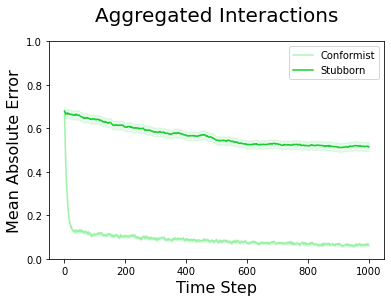

In [31]:
# convert to matrix
error1_mat = np.array(agent1_errors)
error2_mat = np.array(agent2_errors)

mean_error1 = np.average(error1_mat, axis=0)
mean_error2 = np.average(error2_mat, axis=0)
std_error1  = error1_mat.std(0)
std_error2  = error2_mat.std(0)
t = [n for n in range(trials)]
ci1 = 1.96 * std_error1/np.sqrt(trials)
ci2 = 1.96 * std_error2/np.sqrt(trials)

upper1 = mean_error1+ci1
lower1 = mean_error1-ci1
upper1 = upper1.reshape(trials,)
lower1 = lower1.reshape(trials,)
upper2 = mean_error2+ci2
lower2 = mean_error2-ci2
upper2 = upper2.reshape(trials,)
lower2 = lower2.reshape(trials,)
fig, ax = plt.subplots()
ax.plot(t,mean_error1, color=color2c,label="Conformist")
ax.plot(t,mean_error2, color=color2, label="Stubborn")
ax.fill_between(t, lower1, upper1, color=color2c, alpha=.1)
ax.fill_between(t, lower2, upper2, color=color2, alpha=.1)
plt.legend()
plt.ylim(0,1)
plt.title("Aggregated Interactions", fontsize=20, pad=20)
plt.xlabel("Time Step", fontsize=16)
plt.ylabel("Mean Absolute Error", fontsize=16)


### Conformist

In [32]:
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
B1 = np.random.rand(2, 2)
B2 = np.random.rand(2, 2)

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.random.rand(2, 2)
A2 = np.random.rand(2, 2)

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.random.rand(1, 2)
R2 = np.random.rand(1, 2)

# Initial behavior
behav_1 = np.random.rand(1, 2)
behav_2 = np.random.rand(1, 2)

# transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
T1 = np.array([0.2])
T2 = np.array([0.2])

color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]

# get the state observation (behaviors of others)
def sense(inputs):
    perception = inputs
    return perception

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a control signal
def control(error, behavioral_model, previous_output):
    control_signal = chaotic_controller(behavioral_model, 0.01, error)
    return control_signal

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    new_state[new_state > 1] = 1
    new_state[new_state < 0] = 0
    return new_state


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# adjusts reference given error
def reference_update_true(reference, error):
    k = 0.1
    reference = reference - (error * k)
    reference[reference > 1] = 1
    reference[reference < 0] = 0
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate * previous_state) + (behavioral_model * previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate


agent1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)
plant1 = Plant(transition_matrix=T1, transition_function=transition, state=behav_1)

agent2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
system_estimate=A2, reference=R2, init_behavior=behav_2)
plant2 = Plant(transition_matrix=T2, transition_function=transition, state=behav_2)

In [33]:
%matplotlib inline
np.random.seed(11)
trials = 1000
color = (0.1,0.2,0.8,0.1)
agent1_control = []
agent2_control = []
agent1_behaviors = []
agent2_behaviors = []
agent1_error = []
agent2_error = []
t9 = ['-1', '0', '50', '100', '150', '200', '150', '100', '50', '0',  '-1']

b1 = behav_1
b2 = behav_2

for t in range(trials):
    color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
    color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
    #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
    #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
    b1_control = agent1.go(b2)   
    b2_control = agent2.go(b1)

    agent1_control.append(agent1.get_output())
    agent2_control.append(agent2.get_output())

    b1 = plant1.transition(b1_control)
    b2 = plant2.transition(b2_control)

    agent1_behaviors.append(b1)
    agent2_behaviors.append(b2)

    # avg_abs_error = np.sum(abs(dif))/len(dif)
    agent1_error.append(np.sum(np.absolute(agent1.get_error()))/len(agent1.get_error()))
    agent2_error.append(np.sum(np.absolute(agent2.get_error()))/len(agent2.get_error()))
    # agent1_error.append(np.absolute(agent1.get_error()))
    # agent2_error.append(np.absolute(agent2.get_error()))

#     if t % 25 == 0:
#         pl.scatter(b1[0],-1+(t+1)/(trials+1),c=tuple(color1))
#         pl.scatter(b2[0],1-(t+1)/(trials+1),c=tuple(color2))
#         pl.scatter(agent1.get_reference()[0],1-(t+1)/(trials+1),c=tuple(color1), marker="_")
#         pl.scatter(agent2.get_reference()[0],-1+(t+1)/(trials+1),c=tuple(color2), marker="_")
#         display.clear_output(wait=True)
#         display.display(pl.gcf())
#         plt.legend([b1, b2, [agent1.get_reference()[0],0.00],[agent2.get_reference()[0],0.00]], labels=["Conformist Behavior", "Stubborn Behavior","Conformist Reference Signal", "Stubborn Reference Signal"])
#         lg = plt.gca().get_legend()
#         lg.legendHandles[0].set_color((0.1,0.1,0.8))
#         # lg.legendHandles[0].set_edgecolor((0.1,0.1,0.8))
#         lg.legendHandles[1].set_color((0.1,0.8,0.1))
#         # lg.legendHandles[1].set_edgecolor((0.1,0.8,0.1))
#         lg.legendHandles[2].set_color((0.1,0.1,0.8))
#         lg.legendHandles[3].set_color((0.1,0.8,0.1))
#         pl.title("Conformist Interaction with Stubborn Agent", fontsize=20, pad=20)
#         plt.xlabel("Behavior Value (X Position)", fontsize=16)
#         plt.ylabel("Time Step", fontsize=16)
#     #time.sleep(0.1)
# plt.gca().set_yticklabels(t9)


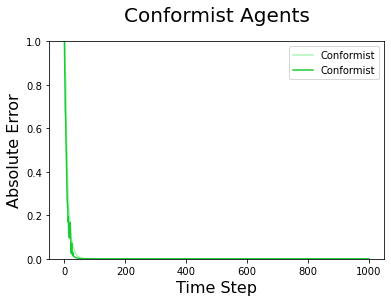

In [34]:
t = [n for n in range(trials)]
plt.plot(t, agent1_error, color=color2c,label="Conformist")
plt.plot(t, agent2_error, color=color2, label="Conformist")
#plt.ylim([0, 1])
plt.legend()
plt.title("Conformist Agents", fontsize=20, pad=20)
plt.xlabel("Time Step", fontsize=16)
plt.ylabel("Absolute Error", fontsize=16)
plt.ylim(0,1)
plt.show()

In [35]:
# run experiments
experiments = 400
trials = 1000
color = (0.1,0.2,0.8,0.1)
np.random.seed(29)
agent1_errors = []
agent2_errors = []

#pl.scatter(R1[0],0, c=(0.1,0.8,0.8), edgecolors=[0.8,0.1,0.1], linewidths=1.5)
for e in range(experiments):
    agent1_control = []
    agent2_control = []
    agent1_behaviors = []
    agent2_behaviors = []
    agent1_error = []
    agent2_error = []
    R1 = np.random.rand(1,2)
    R2 = np.random.rand(1,2)

    # Initial behavior
    behav_1 = np.random.rand(1,2)
    behav_2 = np.random.rand(1,2)

    
    agent1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)
    plant1 = Plant(transition_matrix=T1, transition_function=transition, state=behav_1)

    agent2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
    system_estimate=A2, reference=R2, init_behavior=behav_2)
    plant2 = Plant(transition_matrix=T2, transition_function=transition, state=behav_2)

    b1 = behav_1
    b2 = behav_2
    for t in range(trials):
        b1_control = agent1.go(b2)   
        b2_control = agent2.go(b1)

        agent1_control.append(agent1.get_output())
        agent2_control.append(agent2.get_output())

        b1 = plant1.transition(b1_control)
        b2 = plant2.transition(b2_control)

        agent1_behaviors.append(b1)
        agent2_behaviors.append(b2)

        agent1_error.append(np.sum(np.absolute(agent1.get_error()))/len(agent1.get_error()))
        agent2_error.append(np.sum(np.absolute(agent2.get_error()))/len(agent2.get_error()))
        # agent1_error.append(np.absolute(agent1.get_error()))
        # agent2_error.append(np.absolute(agent2.get_error()))
        # aggregate the errors across experiments
    agent1_errors.append(agent1_error)
    agent2_errors.append(agent2_error)

Text(0, 0.5, 'Mean Absolute Error')

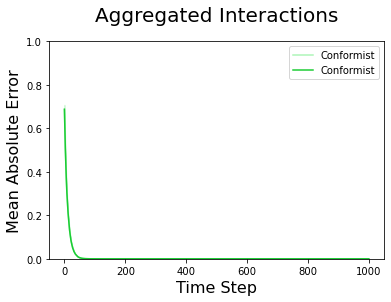

In [36]:
# convert to matrix
error1_mat = np.array(agent1_errors)
error2_mat = np.array(agent2_errors)

mean_error1 = np.average(error1_mat, axis=0)
mean_error2 = np.average(error2_mat, axis=0)
std_error1  = error1_mat.std(0)
std_error2  = error2_mat.std(0)
t = [n for n in range(trials)]
ci1 = 1.96 * std_error1/np.sqrt(trials)
ci2 = 1.96 * std_error2/np.sqrt(trials)

upper1 = mean_error1+ci1
lower1 = mean_error1-ci1
upper1 = upper1.reshape(trials,)
lower1 = lower1.reshape(trials,)
upper2 = mean_error2+ci2
lower2 = mean_error2-ci2
upper2 = upper2.reshape(trials,)
lower2 = lower2.reshape(trials,)
fig, ax = plt.subplots()
ax.plot(t,mean_error1, color=color2c,label="Conformist")
ax.plot(t,mean_error2, color=color2, label="Conformist")
ax.fill_between(t, lower1, upper1, color=color2c, alpha=.1)
ax.fill_between(t, lower2, upper2, color=color2, alpha=.1)
plt.legend()
plt.ylim(0,1)
plt.title("Aggregated Interactions", fontsize=20, pad=20)
plt.xlabel("Time Step", fontsize=16)
plt.ylabel("Mean Absolute Error", fontsize=16)
